# Self-Supervised Learning with Triplet Loss for Blood Cell Images

In [14]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import os

# 1. Data

In [15]:
class BloodDataset(Dataset):
    """
    Custom dataset for blood cell images (self-supervised learning)
    """
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.data = datasets.ImageFolder(root, transform=transform)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, _ = self.data[idx]  # Ignore the label
        return image

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = BloodDataset('data/images/TRAIN', transform=transform)
test_dataset = BloodDataset('data/images/TEST', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
def imshow(img, label=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if label:
        plt.title(label)
    plt.show()
def show_batch(batch):
    images = batch
    grid = torchvision.utils.make_grid(images)
    imshow(grid)

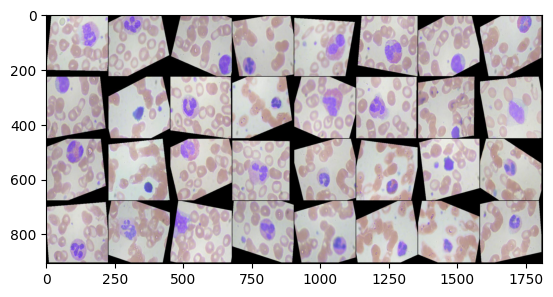

In [18]:
batch = next(iter(train_loader))
show_batch(batch)

# 2. Model

In [19]:
from model import BloodNet
from loss import TripletLoss
from utils import mine_hard_negatives

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [21]:
model = BloodNet().to(device)
criterion = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

BloodNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Anchor:


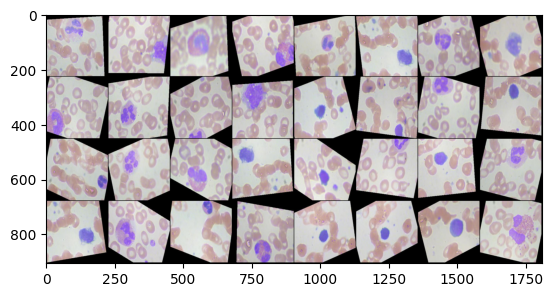

Positive:


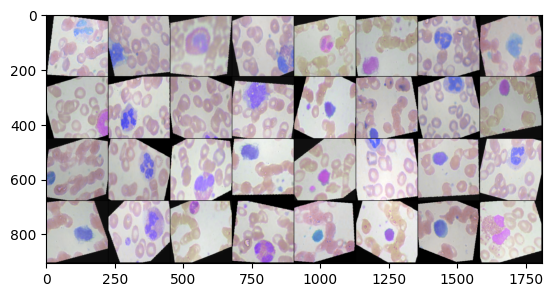

Negative:


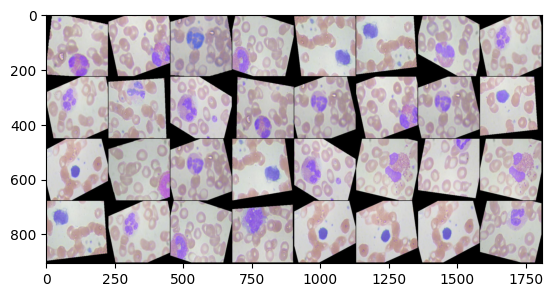

In [22]:
# Find some hard-negative examples on the batch
model.eval()
with torch.no_grad():
    batch = next(iter(train_loader))
    batch = batch.to(device)
    anchor, positive, negative = mine_hard_negatives(model, batch)
    print('Anchor:')
    show_batch(anchor)
    print('Positive:')
    show_batch(positive)
    print('Negative:')
    show_batch(negative)

# 3. Training

In [23]:
# Training loop
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc='Training')):
        batch = batch.to(device)
        optimizer.zero_grad()
        anchor, positives, hard_negatives = mine_hard_negatives(model, batch)
        
        # Forward pass to get embeddings for anchor
        anchor_embeddings = model(anchor)
        
        # Forward pass to get embeddings for positive examples
        positive_embeddings = model(positives)
        
        # Forward pass to get embeddings for hard negatives
        negative_embeddings = model(hard_negatives)
        
        # Compute loss
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        
        # Backward pass
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [24]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    loss = train(model, criterion, optimizer, train_loader, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
    
    # Save the model
    if os.path.exists(f'models/{model}') is False:
        os.makedirs(f'models/{model}')
    torch.save(model.state_dict(), f'models/{model}/{model}-{epoch+1}.pth')

Training:   0%|          | 1/312 [00:00<02:29,  2.09it/s]

Training: 100%|██████████| 312/312 [02:23<00:00,  2.18it/s]


Epoch 1/10, Loss: 0.016303656848135572


Training: 100%|██████████| 312/312 [02:23<00:00,  2.18it/s]


Epoch 2/10, Loss: 0.008577228823784165


Training: 100%|██████████| 312/312 [02:22<00:00,  2.19it/s]


Epoch 3/10, Loss: 0.007859089868501402


Training: 100%|██████████| 312/312 [02:22<00:00,  2.19it/s]


Epoch 4/10, Loss: 0.006373065861109166


Training: 100%|██████████| 312/312 [02:22<00:00,  2.19it/s]


Epoch 5/10, Loss: 0.006054198069390482


Training: 100%|██████████| 312/312 [02:22<00:00,  2.19it/s]


Epoch 6/10, Loss: 0.005047851537640851


Training: 100%|██████████| 312/312 [02:23<00:00,  2.18it/s]


Epoch 7/10, Loss: 0.005242565540799824


Training: 100%|██████████| 312/312 [02:22<00:00,  2.19it/s]


Epoch 8/10, Loss: 0.004612488088568147


Training: 100%|██████████| 312/312 [02:23<00:00,  2.18it/s]


Epoch 9/10, Loss: 0.005125807351970042


Training: 100%|██████████| 312/312 [02:22<00:00,  2.18it/s]

Epoch 10/10, Loss: 0.004897365913702509


# 4. Testing

In [30]:
from sklearn.manifold import TSNE

In [31]:
# Test the model
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(test_loader, total=len(test_loader), desc='Testing'):
        batch = batch.to(device)
        embeddings.append(model(batch).cpu().numpy())
        
embeddings = np.concatenate(embeddings)

Testing:   0%|          | 0/78 [00:00<?, ?it/s]

Testing: 100%|██████████| 78/78 [00:06<00:00, 11.31it/s]


In [32]:
# Apply K-means clustering to the embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
pseudo_labels = kmeans.fit(embeddings)

In [33]:
# Visualize the embeddings using t-SNE
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(embeddings)

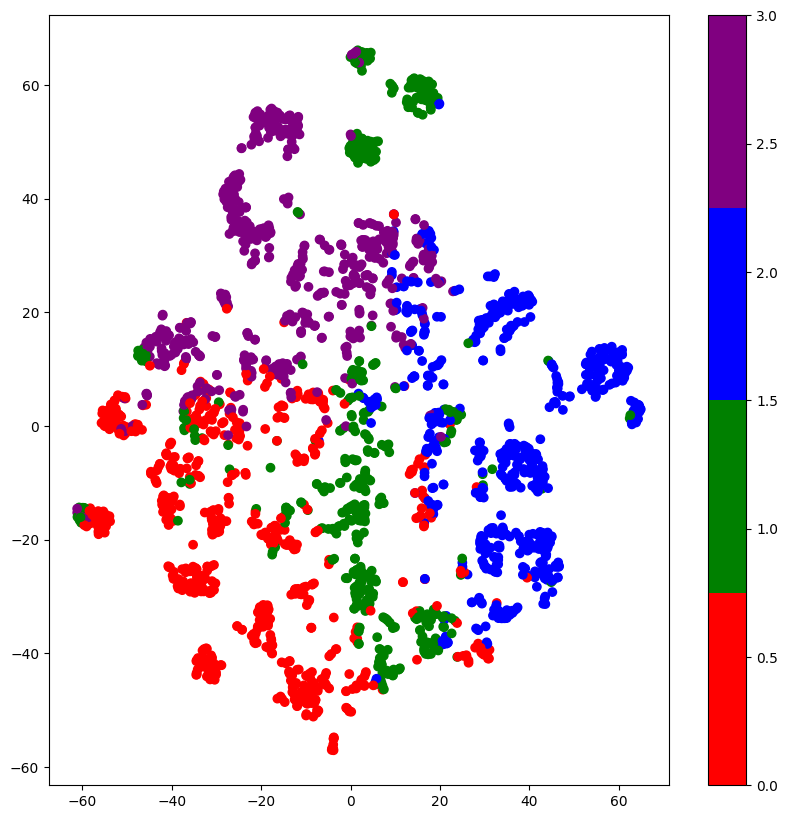

In [34]:
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple']
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pseudo_labels.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.colorbar()
plt.show()